# Прогнозирование изменения цены акций в краткосрочном периоде

# УСТАНОВКА APIMOEX И TALIB

In [2]:
import requests # ИНТЕРНЕТ (HTTP)
import os # РАБОТА С ОПЕРАЦИОННОЙ СИСТЕМОЙ

# УСТАНОВКА APIMOEX
try:
    import apimoex
except ImportError:
    os.system(f"pip install apimoex")
    
# УСТАНОВКА TALIB
python_version = "311" # ВАША ВЕРСИЯ ПИТОНА ВИДА NNN (ЕСЛИ ВЕРСИЯ 3.11, НАДО НАПИСАТЬ 311)
try:
    import talib
except ImportError:
    print("Библиотека talib не установлена. Начало установки")
    current_directory = os.getcwd()
    file_name = "TA_Lib-0.4.28-cp" + python_version + "-cp" + python_version + "-win_amd64.whl"
    url = 'https://github.com/cgohlke/talib-build/releases/download/v0.4.28/' + file_name
    response = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(response.content)
    os.system(f"pip install {file_name}")
    if os.path.exists(file_name):
        os.remove(file_name)

# ИМПОРТ БИБЛИОТЕК

In [1]:
import apimoex # МОСКОВСКАЯ БИРЖА
import mplfinance as mpf # ФИНАНСОВЫЕ ГРАФИКИ (СВЕЧИ) #pip install --upgrade mplfinance
import talib # БИБЛИОТЕКА ТЕХНИЧЕСКОГО АНАЛИЗА
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
warnings.filterwarnings("ignore")

# ПАРСИНГ СВЕЧЕЙ С МОСБИРЖИ

In [3]:
def get_candles(start_date: str, ticker: str, timeframe: int) -> pd.DataFrame:
    """Функция для получения свечей выбранного инструмента с произвольной даты и указанного таймфрейма
    
    Args:
        start_date (str): Начальная дата, с которой загружаются свечи. Вид: YYYY-MM-DD
        ticker (str): Тикер инструмента
        timeframe (int): Таймфрейм свечи (1 - 1M, 10 - 10M, 60 - 1H, 24 - 1D, 7 - 1W, 31 - 1 month, 4 - 1 quarter)

    Returns:
        pd.DataFrame: Pandas DataFrame с свечами по инструменту
    """   
    with requests.Session() as session:
        if ticker == "IMOEX":
            data = apimoex.get_market_candles(session, "IMOEX", interval = timeframe, start = start_date, market = 'index')
        else:
            data = apimoex.get_market_candles(session, ticker, interval = timeframe, start = start_date)            
        candles = pd.DataFrame(data)
        last_candle_time = candles.iloc[-1]['begin']
        print(f'Время обновления: {datetime.now().replace(microsecond = 0)}')
        print(f'Количество свеч по {ticker}: {candles.shape[0]}. Дата начала: {start_date}')
        print(f'Время последней полученной свечи: {last_candle_time} \n')
        return candles
     

In [4]:
sber = get_candles("2024-04-01", "SBER", 1)
sber.head()

Время обновления: 2024-05-11 19:00:50
Количество свеч по SBER: 23531. Дата начала: 2024-04-01
Время последней полученной свечи: 2024-05-10 23:49:00 



,begin,open,close,high,low,value,volume
0,2024-04-01 09:59:00,300.00,300.00,300.00,300.00,85374000.0,284580
1,2024-04-01 10:00:00,299.99,299.64,299.99,299.50,212662883.3,709390
2,2024-04-01 10:01:00,299.74,299.99,299.99,299.57,126131458.7,420680
3,2024-04-01 10:02:00,299.99,300.00,300.00,299.89,266268968.3,887580
4,2024-04-01 10:03:00,299.99,300.00,300.00,299.99,100697702.2,335660


In [5]:
imoex = get_candles("2024-04-01", "IMOEX", 1)
imoex.head()

Время обновления: 2024-05-11 19:00:52
Количество свеч по IMOEX: 15138. Дата начала: 2024-04-01
Время последней полученной свечи: 2024-05-10 18:50:00 



,begin,open,close,high,low,value,volume
0,2024-04-01 10:00:00,3343.66,3348.72,3348.72,3343.66,1.363007e+09,0
1,2024-04-01 10:01:00,3348.21,3346.77,3348.43,3346.63,8.834403e+08,0
2,2024-04-01 10:02:00,3346.77,3347.73,3347.96,3346.77,8.215581e+08,0
3,2024-04-01 10:03:00,3347.63,3349.20,3349.28,3347.51,7.425619e+08,0
4,2024-04-01 10:04:00,3349.19,3351.54,3351.54,3348.87,8.654595e+08,0


# Предварительная обработка данных

In [6]:
# ПРИВОДИМ К НУЖНОМУ ВИДУ БАЗУ ДАННЫХ ПО ИНСТРУМЕНТУ
# ПОХОДУ VOLUME ИЗМЕРЯЕТСЯ В ТЫСЯЧАХ ЛОТОВ, ПРОВЕРИТЬ
def format_values(name: pd.DataFrame) -> pd.DataFrame:
    """Функция для обработки базы данных свечей. Приводит базу к нужному виду 

    Args:
        name (pd.DataFrame): DataFrame со свечами по инструменту

    Returns:
        pd.DataFrame: База данных, приведенная к нужному для анализа виду
    """       
    name.rename(columns = {'open':"Open", "close":"Close", "high":"High", "low":"Low", "volume":"Volume"}, inplace = True) # ПЕРЕИМЕНОВАЛИ ДЛЯ ГРАФИКА ЧЕРЕЗ MPF. ЕСЛИ НЕ ИСПОЛЬЗОВАТЬ, ТО НЕ НАДО
    name['begin'] = name['begin'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')) # ПРЕОБРАЗОВЫВАЕМ СТРОКУ В ДАТУ
    name = name[(name['begin'].dt.strftime('%H:%M') < "18:40") & (name['begin'].dt.strftime('%H:%M') >= "10:00")] # ОСТАВЛЯЕМ ТОЛЬКО ДНЕВНУЮ СЕССИЮ
    name.set_index("begin", inplace = True) # СТАВИМ ДАТУ КАК ИНДЕКС
    return name

In [7]:
sber = format_values(sber)
sber.head()

,Open,Close,High,Low,value,Volume
begin,,,,,,
2024-04-01 10:00:00,299.99,299.64,299.99,299.50,212662883.3,709390
2024-04-01 10:01:00,299.74,299.99,299.99,299.57,126131458.7,420680
2024-04-01 10:02:00,299.99,300.00,300.00,299.89,266268968.3,887580
2024-04-01 10:03:00,299.99,300.00,300.00,299.99,100697702.2,335660
2024-04-01 10:04:00,300.00,300.49,300.50,299.99,200596062.8,668150


In [8]:
# РАСЧЕТЫ НА ОСНОВЕ ОСНОВНЫХ ПОКАЗАТЕЛЕЙ. ВРОДЕ БЫ ВЕЗДЕ ДОЛИ, НО МОЖНО И ПРОЦЕНТЫ (ПРОВЕРИТЬ ЧТОБЫ ВСЕ БЫЛО ОДНООБРАЗНО)
def get_candle_characteristics(name: pd.DataFrame) -> pd.DataFrame:
    """Функция для расчета основных характеристик свечи по ее параметрам

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту

    Returns:
        pd.DataFrame: База данных с посчитанными характеристиками свечей
    """    
    name["body"] = abs(name['Close'] - name["Open"])/(name["High"] - name["Low"]) # ОТНОШЕНИЕ ТЕЛА СВЕЧИ КО ВСЕЙ СВЕЧЕ
    name['body'].fillna(0, inplace = True) # ГДЕ HIGH = LOW ПИШЕМ 0
    name['colour'] = name.apply(lambda row: "green" if row['Close'] >= row["Open"] else "red", axis = 1) # КОДИРУЕМ ЦВЕТ СВЕЧИ
    #name['session'] = name.apply(lambda row: 'main' if row.name.time() < datetime.strptime('19:00', '%H:%M').time() else 'evening', axis = 1) # ТОРГОВАЯ СЕССИЯ
    name['change'] = (name['Close']- name['Open'])/name['Open'] # ИЗМЕНЕНИЕ ЦЕНЫ ЗА МИНУТУ
    name['span_up'] = name.apply(lambda row: (row['High'] - row['Open'])/row['Open'] if row["Open"] >= row['Close'] else (row['High'] - row['Close'])/row['Close'] , axis = 1) # ОТКЛОНЕНИЕ НАВЕРХ (ТЕНЬ)
    name['span_down'] = name.apply(lambda row: (row['Close'] - row['Low'])/row['Close'] if row["Open"] >= row['Close'] else (row['Open'] - row['Low'])/row['Open'] , axis = 1) # ОТКЛОНЕНИЕ ВНИЗ (ТЕНЬ)
    return name

In [9]:
sber = get_candle_characteristics(sber)
sber.head()

,Open,Close,High,Low,value,Volume,body,colour,change,span_up,span_down
begin,,,,,,,,,,,
2024-04-01 10:00:00,299.99,299.64,299.99,299.50,212662883.3,709390,0.714286,red,-0.001167,0.000000,0.000467
2024-04-01 10:01:00,299.74,299.99,299.99,299.57,126131458.7,420680,0.595238,green,0.000834,0.000000,0.000567
2024-04-01 10:02:00,299.99,300.00,300.00,299.89,266268968.3,887580,0.090909,green,0.000033,0.000000,0.000333
2024-04-01 10:03:00,299.99,300.00,300.00,299.99,100697702.2,335660,1.000000,green,0.000033,0.000000,0.000000
2024-04-01 10:04:00,300.00,300.49,300.50,299.99,200596062.8,668150,0.960784,green,0.001633,0.000033,0.000033


In [10]:
def get_TA(name: pd.DataFrame, n: int) -> pd.DataFrame:
    """Функция для расчета значений индикаторов технического анализа 

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту
        n (int): Количество первых свечей для удаления (чтобы не было NaN у индикаторов и все они были посчитаны)

    Returns:
        pd.DataFrame: База данных с посчитанными значениями индикаторов
    """    
    name["rsi"] = talib.RSI(name['Close'], timeperiod = 14) # RSI
    macd, macdsignal, name['macdhist'] = talib.MACD(name['Close'], fastperiod = 12, slowperiod = 26, signalperiod = 9) # MACD
    name['slowk'], name['slowd'] = talib.STOCH(name['High'], name['Low'], name['Close'], fastk_period = 14, slowk_period = 1, slowk_matype = 0, slowd_period = 3, slowd_matype = 0) # STOCHASTIC
    name['adx'] = talib.ADX(name['High'], name['Low'], name['Close'], timeperiod = 14) #ADX
    name['atr'] = talib.ATR(name['High'], name['Low'], name['Close'], timeperiod = 14) #ATR
    name = name[n:]  # УДАЛЯЕМ ПЕРВЫЕ СТРОКИ ЧТОБЫ У ИНДИКАТОРОВ НЕ БЫЛО NaN. ПОДКОРРЕКТИРОВАТЬ В ЗАВИСИМОСТИ ОТ ПЕРИОДОВ ИНДИКАТОРОВ
    return name

In [11]:
sber = get_TA(sber, 33)
sber.head()

,Open,Close,High,Low,value,Volume,body,colour,change,span_up,span_down,rsi,macdhist,slowk,slowd,adx,atr
begin,,,,,,,,,,,,,,,,,
2024-04-01 10:33:00,301.13,301.05,301.13,301.05,3.404058e+07,113060,1.000000,red,-0.000266,0.000000,0.000000,63.117387,0.021829,70.588235,75.686275,25.272460,0.168871
2024-04-01 10:34:00,301.05,301.07,301.12,301.04,3.956942e+07,131430,0.250000,green,0.000066,0.000166,0.000033,63.573278,0.012708,72.941176,74.509804,25.187264,0.162524
2024-04-01 10:35:00,301.08,301.28,301.30,301.07,4.630021e+07,153710,0.869565,green,0.000664,0.000066,0.000033,68.040286,0.018272,97.647059,80.392157,25.808685,0.167343
2024-04-01 10:36:00,301.30,301.42,301.44,301.28,4.500202e+07,149330,0.750000,green,0.000398,0.000066,0.000066,70.626398,0.028239,97.647059,89.411765,26.846801,0.166819
2024-04-01 10:37:00,301.42,301.40,301.44,301.40,8.795234e+06,29180,0.500000,red,-0.000066,0.000066,0.000000,69.757987,0.030168,94.520548,96.604889,27.810766,0.157760


In [12]:
# СВЕЧНЫЕ ПАТТЕРНЫ
def get_candle_patterns(name: pd.DataFrame) -> pd.DataFrame:
    """Функция для распознования свечных паттернов

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту

    Returns:
        pd.DataFrame: База данных со свечными паттернами
    """    
    name['engulfing'] = talib.CDLENGULFING(name['Open'], name['High'], name['Low'], name['Close'])/100  # ENGULFING CANDLE
    name['doji'] = talib.CDLDOJI(name['Open'], name['High'], name['Low'], name['Close'])/100  # DOJI CANDLE
    name['hammer'] = talib.CDLHAMMER(name['Open'], name['High'], name['Low'], name['Close'])/100  # HAMMER CANDLE
    name['inv_hammer'] = talib.CDLINVERTEDHAMMER(name['Open'], name['High'], name['Low'], name['Close'])/100  # INVERTED HAMMER CANDLE
    name['shooting_star'] = talib.CDLSHOOTINGSTAR(name['Open'], name['High'], name['Low'], name['Close'])/100  # SHOOTING STAR CANDLE
    name['marubuzu'] = talib.CDLMARUBOZU(name['Open'], name['High'], name['Low'], name['Close'])/100  # MARUBOZU STAR CANDLE
    return name

In [13]:
sber = get_candle_patterns(sber)
sber.head()

,Open,Close,High,Low,value,Volume,body,colour,change,span_up,...,slowk,slowd,adx,atr,engulfing,doji,hammer,inv_hammer,shooting_star,marubuzu
begin,,,,,,,,,,,,,,,,,,,,,
2024-04-01 10:33:00,301.13,301.05,301.13,301.05,3.404058e+07,113060,1.000000,red,-0.000266,0.000000,...,70.588235,75.686275,25.272460,0.168871,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-01 10:34:00,301.05,301.07,301.12,301.04,3.956942e+07,131430,0.250000,green,0.000066,0.000166,...,72.941176,74.509804,25.187264,0.162524,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-01 10:35:00,301.08,301.28,301.30,301.07,4.630021e+07,153710,0.869565,green,0.000664,0.000066,...,97.647059,80.392157,25.808685,0.167343,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-01 10:36:00,301.30,301.42,301.44,301.28,4.500202e+07,149330,0.750000,green,0.000398,0.000066,...,97.647059,89.411765,26.846801,0.166819,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-01 10:37:00,301.42,301.40,301.44,301.40,8.795234e+06,29180,0.500000,red,-0.000066,0.000066,...,94.520548,96.604889,27.810766,0.157760,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def get_target_answers(name: pd.DataFrame) -> tuple: 
    """Функция, возвращающая цвет следующей свечи и записывающая его в базу данных со свечами по инструменту

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту

    Returns:
        tuple: Кортеж, содержащий DataFrame с обновленными данными и массив с правильными ответами (цвет следующей свечи)
    """       
    y = name["change"][1:].values # ПОЛУЧАЕМ ВСЕ СВЕЧИ КРОМЕ ПЕРВОЙ
    name = name[:-1] # УДАЛЯЕМ ПОСЛЕДНЮЮ СТРОКУ, ДЛЯ НЕЕ НЕТ ПРОГНОЗА
    name['target'] = y # ЗАПИСЫВАЕМ ОТВЕТЫ
    return name, y

In [15]:
sber, sber_y = get_target_answers(sber)
print(sber.shape)
sber.head()

(15046, 24)


,Open,Close,High,Low,value,Volume,body,colour,change,span_up,...,slowd,adx,atr,engulfing,doji,hammer,inv_hammer,shooting_star,marubuzu,target
begin,,,,,,,,,,,,,,,,,,,,,
2024-04-01 10:33:00,301.13,301.05,301.13,301.05,3.404058e+07,113060,1.000000,red,-0.000266,0.000000,...,75.686275,25.272460,0.168871,0.0,0.0,0.0,0.0,0.0,0.0,0.000066
2024-04-01 10:34:00,301.05,301.07,301.12,301.04,3.956942e+07,131430,0.250000,green,0.000066,0.000166,...,74.509804,25.187264,0.162524,0.0,0.0,0.0,0.0,0.0,0.0,0.000664
2024-04-01 10:35:00,301.08,301.28,301.30,301.07,4.630021e+07,153710,0.869565,green,0.000664,0.000066,...,80.392157,25.808685,0.167343,0.0,0.0,0.0,0.0,0.0,0.0,0.000398
2024-04-01 10:36:00,301.30,301.42,301.44,301.28,4.500202e+07,149330,0.750000,green,0.000398,0.000066,...,89.411765,26.846801,0.166819,0.0,0.0,0.0,0.0,0.0,0.0,-0.000066
2024-04-01 10:37:00,301.42,301.40,301.44,301.40,8.795234e+06,29180,0.500000,red,-0.000066,0.000066,...,96.604889,27.810766,0.157760,0.0,0.0,0.0,0.0,0.0,0.0,-0.000332


In [16]:
# ПРОВЕРЯЕМ ЕСТЬ ЛИ ПРОПУСКИ В ДАННЫХ

sber.isnull().sum()

Open             0
Close            0
High             0
Low              0
value            0
Volume           0
body             0
colour           0
change           0
span_up          0
span_down        0
rsi              0
macdhist         0
slowk            0
slowd            0
adx              0
atr              0
engulfing        0
doji             0
hammer           0
inv_hammer       0
shooting_star    0
marubuzu         0
target           0
dtype: int64

In [27]:
.boxplot(sber['Open'])

AttributeError: 'Series' object has no attribute 'boxplot'

In [17]:
#ВСЕ ФУНКЦИИ В ОДНОМ МЕСТЕ НА ПРИМЕРЕ ЛУКОЙЛА
lukoil = get_candles("2024-04-01", "LKOH", 1)
lukoil = format_values(lukoil)
lukoil = get_candle_characteristics(lukoil)
lukoil = get_TA(lukoil, 33)
lukoil = get_candle_patterns(lukoil)
lukoil, lukoil_y = get_target_answers(lukoil)
print(lukoil.shape)
lukoil.tail()

Время обновления: 2024-05-11 19:01:10
Количество свеч по LKOH: 23439. Дата начала: 2024-04-01
Время последней полученной свечи: 2024-05-10 23:49:00 

(15046, 24)


,Open,Close,High,Low,value,Volume,body,colour,change,span_up,...,slowd,adx,atr,engulfing,doji,hammer,inv_hammer,shooting_star,marubuzu,target
begin,,,,,,,,,,,,,,,,,,,,,
2024-05-10 18:34:00,7717.0,7716.5,7717.0,7716.5,763963.5,99,1.0,red,-0.000065,0.000000,...,5.555556e+00,21.582015,0.879144,0.0,0.0,0.0,0.0,0.0,-1.0,0.000000
2024-05-10 18:35:00,7716.5,7716.5,7717.0,7716.5,2924625.5,379,0.0,green,0.000000,0.000065,...,5.555556e+00,23.470194,0.852063,0.0,1.0,0.0,0.0,0.0,0.0,-0.000130
2024-05-10 18:36:00,7717.0,7716.0,7717.0,7716.0,1010859.5,131,1.0,red,-0.000130,0.000000,...,-1.203186e-12,25.671563,0.862630,-1.0,0.0,0.0,0.0,0.0,-1.0,0.000065
2024-05-10 18:37:00,7716.0,7716.5,7716.5,7716.0,810205.0,105,1.0,green,0.000065,0.000000,...,5.555556e+00,27.715691,0.836727,0.0,0.0,0.0,0.0,0.0,1.0,-0.000065
2024-05-10 18:38:00,7716.5,7716.0,7716.5,7716.0,6311751.5,818,1.0,red,-0.000065,0.000000,...,5.555556e+00,29.613811,0.812676,0.0,0.0,0.0,0.0,0.0,-1.0,0.000065


In [18]:
sber.columns

Index(['Open', 'Close', 'High', 'Low', 'value', 'Volume', 'body', 'colour',
       'change', 'span_up', 'span_down', 'rsi', 'macdhist', 'slowk', 'slowd',
       'adx', 'atr', 'engulfing', 'doji', 'hammer', 'inv_hammer',
       'shooting_star', 'marubuzu', 'target'],
      dtype='object')

In [31]:
min5value = sber.sort_values(by = 'value', ascending=True).head(20)
min5value


,Open,Close,High,Low,value,Volume,body,colour,change,span_up,...,slowd,adx,atr,engulfing,doji,hammer,inv_hammer,shooting_star,marubuzu,target
begin,,,,,,,,,,,,,,,,,,,,,
2024-04-30 12:42:00,308.49,308.49,308.49,308.49,24679.2,80,0.0,green,0.000000,0.000000,...,8.320106e+01,23.090274,0.025036,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2024-05-10 15:09:00,313.02,313.05,313.08,313.02,28174.8,90,0.5,green,0.000096,0.000096,...,3.625479e+01,37.675965,0.062055,0.0,0.0,0.0,0.0,0.0,0.0,0.000096
2024-04-30 12:53:00,308.44,308.44,308.44,308.43,33927.9,110,0.0,green,0.000000,0.000000,...,1.031746e+01,20.213681,0.018920,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2024-05-07 12:53:00,307.14,307.16,307.16,307.14,36857.7,120,1.0,green,0.000065,0.000000,...,8.478571e+01,26.722627,0.053960,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
2024-04-30 14:28:00,308.31,308.31,308.31,308.30,43163.0,140,0.0,green,0.000000,0.000000,...,9.333333e+01,13.932807,0.021487,0.0,1.0,0.0,0.0,0.0,0.0,-0.000032
2024-04-30 14:30:00,308.30,308.29,308.30,308.29,46244.4,150,1.0,red,-0.000032,0.000000,...,8.000000e+01,13.649493,0.021894,0.0,0.0,0.0,0.0,0.0,-1.0,0.000065
2024-04-30 13:24:00,308.30,308.30,308.31,308.30,46245.4,150,0.0,green,0.000000,0.000032,...,7.350427e+00,44.456914,0.019047,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2024-04-30 16:32:00,308.11,308.11,308.11,308.10,49297.1,160,0.0,green,0.000000,0.000000,...,6.666667e+01,11.764698,0.019546,0.0,1.0,0.0,0.0,0.0,0.0,0.000162
2024-05-10 15:12:00,313.08,313.10,313.10,313.08,53224.3,170,1.0,green,0.000064,0.000000,...,5.654762e+01,37.075742,0.058883,0.0,0.0,0.0,0.0,0.0,0.0,0.000032


In [54]:
sber1 = sber.drop(columns =  ["Open", "Close", "High", "Low"])
X = pd.concat([sber1.shift(i).add_suffix(str(i)) for i in range(3)], axis=1).dropna()

In [55]:
X.columns

Index(['value0', 'Volume0', 'body0', 'colour0', 'change0', 'span_up0',
       'span_down0', 'rsi0', 'macdhist0', 'slowk0', 'slowd0', 'adx0', 'atr0',
       'engulfing0', 'doji0', 'hammer0', 'inv_hammer0', 'shooting_star0',
       'marubuzu0', 'target0', 'value1', 'Volume1', 'body1', 'colour1',
       'change1', 'span_up1', 'span_down1', 'rsi1', 'macdhist1', 'slowk1',
       'slowd1', 'adx1', 'atr1', 'engulfing1', 'doji1', 'hammer1',
       'inv_hammer1', 'shooting_star1', 'marubuzu1', 'target1', 'value2',
       'Volume2', 'body2', 'colour2', 'change2', 'span_up2', 'span_down2',
       'rsi2', 'macdhist2', 'slowk2', 'slowd2', 'adx2', 'atr2', 'engulfing2',
       'doji2', 'hammer2', 'inv_hammer2', 'shooting_star2', 'marubuzu2',
       'target2', 'value3', 'Volume3', 'body3', 'colour3', 'change3',
       'span_up3', 'span_down3', 'rsi3', 'macdhist3', 'slowk3', 'slowd3',
       'adx3', 'atr3', 'engulfing3', 'doji3', 'hammer3', 'inv_hammer3',
       'shooting_star3', 'marubuzu3', 'target3'

(array([7.510e+02, 1.288e+03, 1.356e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([8.00000000e+01, 2.74736333e+03, 5.41472667e+03, ...,
        7.99683527e+06, 7.99950264e+06, 8.00217000e+06]),
 <BarContainer object of 3000 artists>)

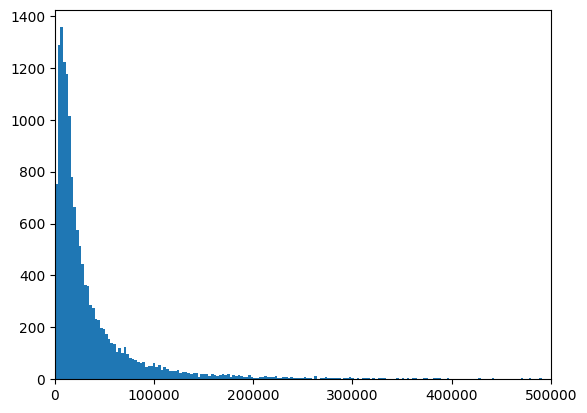

In [51]:
plt.xlim(0,500000)
plt.hist(sber['Volume'], bins = 3000)

In [20]:
X.head()

,value0,Volume0,body0,colour0,change0,span_up0,span_down0,rsi0,macdhist0,slowk0,...,slowd2,adx2,atr2,engulfing2,doji2,hammer2,inv_hammer2,shooting_star2,marubuzu2,target2
begin,,,,,,,,,,,,,,,,,,,,,
2024-04-01 10:35:00,46300212.1,153710,0.869565,green,0.000664,0.000066,0.000033,68.040286,0.018272,97.647059,...,75.686275,25.272460,0.168871,0.0,0.0,0.0,0.0,0.0,0.0,0.000066
2024-04-01 10:36:00,45002021.5,149330,0.750000,green,0.000398,0.000066,0.000066,70.626398,0.028239,97.647059,...,74.509804,25.187264,0.162524,0.0,0.0,0.0,0.0,0.0,0.0,0.000664
2024-04-01 10:37:00,8795233.6,29180,0.500000,red,-0.000066,0.000066,0.000000,69.757987,0.030168,94.520548,...,80.392157,25.808685,0.167343,0.0,0.0,0.0,0.0,0.0,0.0,0.000398
2024-04-01 10:38:00,40095095.0,133040,0.833333,red,-0.000332,0.000066,0.000000,65.426227,0.021785,77.419355,...,89.411765,26.846801,0.166819,0.0,0.0,0.0,0.0,0.0,0.0,-0.000066
2024-04-01 10:39:00,16897163.6,56080,1.000000,green,0.000033,0.000000,0.000000,65.655898,0.014347,71.739130,...,96.604889,27.810766,0.157760,0.0,0.0,0.0,0.0,0.0,0.0,-0.000332


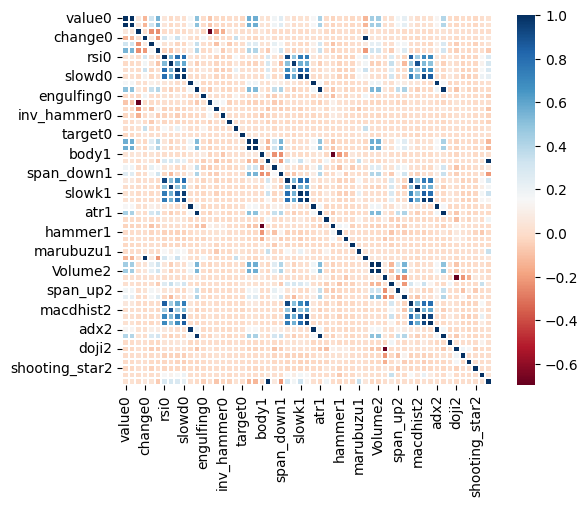

In [21]:
sns.heatmap(X.corr(method='pearson', numeric_only=True), 
           square=True, fmt=".1f", 
          linewidths=0.1, cmap="RdBu");

In [22]:
X.describe()

,value0,Volume0,body0,change0,span_up0,span_down0,rsi0,macdhist0,slowk0,slowd0,...,slowd2,adx2,atr2,engulfing2,doji2,hammer2,inv_hammer2,shooting_star2,marubuzu2,target2
count,1.504400e+04,1.504400e+04,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,1.504400e+04,...,1.504400e+04,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000,15044.000000
mean,1.337603e+07,4.345331e+04,0.530459,0.000001,0.000045,0.000060,50.790270,-0.000054,52.219355,5.222012e+01,...,5.222344e+01,27.275578,0.081179,-0.007179,0.212909,0.042874,0.014823,-0.003058,0.005717,0.000001
std,3.429151e+07,1.105052e+05,0.355602,0.000280,0.000089,0.000114,13.431251,0.031185,33.309714,3.115134e+01,...,3.115245e+01,10.968327,0.055033,0.161679,0.409377,0.202580,0.120849,0.055214,0.319907,0.000280
min,2.467920e+04,8.000000e+01,0.000000,-0.008952,0.000000,0.000000,5.522111,-0.472005,0.000000,-5.021169e-13,...,-5.021169e-13,6.876190,0.012906,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-0.008952
25%,2.715741e+06,8.837500e+03,0.222222,-0.000065,0.000000,0.000000,41.907677,-0.012450,21.621622,2.402036e+01,...,2.402036e+01,19.202858,0.048594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000065
50%,5.665331e+06,1.847000e+04,0.538462,0.000000,0.000000,0.000033,50.460858,-0.000271,52.941176,5.277778e+01,...,5.277778e+01,25.262164,0.069777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.301967e+07,4.242250e+04,0.857143,0.000065,0.000064,0.000065,59.343031,0.011814,83.870968,8.123133e+01,...,8.123133e+01,33.082621,0.095402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065
max,2.500455e+09,8.002170e+06,1.000000,0.003608,0.002114,0.005349,98.780211,0.292353,100.000000,1.000000e+02,...,1.000000e+02,77.789462,0.804576,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.003608


In [73]:
#plt.rcParams["figure.figsize"] = (15, 5)
#sns.pairplot(sber, hue = 'colour_next_candle')

In [23]:
fig = go.Figure(data=[go.Candlestick(
    x=sber.index.values,
    open=sber['Open'], high=sber['High'],
    low=sber['Low'], close=sber['Close'],
    increasing_line_color= 'green', decreasing_line_color= 'red'
)])

 
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[     
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[19, 10], pattern="hour"),  # hide hours outside of 9.30am-4pm
            # dict(values=["2019-12-25", "2020-12-24"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )

fig.show()

# Описание признаков
**"Японские свечи"** - это наиболее информативная форма графика, применяемая в техническом анализе изменения цен финансовых инструментов. Свеча показывает изменение стоимости актива за определённый промежуток времени, а также минимумы и максимумы цены за данный промежуток.
* **Open** - цена открытия свечи, то есть цена инструмента на начало определённого временного промежутка.
* **Close** - цена закрытия свечи, то есть цена инструмента на конец определённого временного промежутка.
* **High** - максимальная цена инструмента, которую он достиг за определённый промежуток(за соответствующую свечу).
* **Low** - минимальная цена инструмента, до которой он падал за определённый промежуток(за соответствующую свечу).
* **value** - объём торгов по инструменту в деньгах за определённый временной промежуток.
* **Volume** - объём торгов в лотах. Лот на финансовом рынке — это единица измерения пакета ценных бумаг (или других финансовых инструментов) при совершении сделки. Иными словами, лот — минимальное количество актива, которое можно купить или продать. Один лот может содержат в себе 1, 10, 1 000, 10 000, 100 000 и т.д ценных бумаг.
* **body** - отношения тела свечи (разницы между open и close) ко всей свече (разницы high и low)
* **colour** - цвет свечи в зависимости от динамики цены за временной промежуток. Если цена открытия выше цены закрытия, то цена актива упала за данный промежуток (красная свеча). Если цена закрытия выше цены открытия свечи, то цена актива выросла за этот промежуток (зеленая свеча).
* **session** - торговая сессия. У финансовых инструментов есть 3 торговые сессии: утренняя, дневная и вечерняя. У акций есть только дневная (main) и вечерняя (evening) торговые сессии.
* **change** - относительное изменение цены инструмента за промежуток времени.
* **span_up** - верхняя тень свечи, которая указывает на отклонение цены актива вверх относительно тела свечи.
* **span_down** - нижняя тень свечи, которая указывает на отклонение цены актива вниз относительно тела свечи.


Графическое изображение японской свечи:

<p align="center">
<a href="https://ibb.co/Xb2GVJj"><img src="https://i.ibb.co/rm7XvyF/image.png" alt="image" border="0"></a>
</p>

**Технический анализ** - это метод анализа финансовых рынков, основанный на изучении и интерпретации прошлых данных о ценах, объемах и других рыночных параметрах с целью прогнозирования будущих ценовых движений. Он используется в инвестиционной деятельности для принятия решений о покупке, продаже или удержании активов. Технический анализ основан на предположении, что рыночные цены отражают все доступные информационные данные и тенденции, и что исторические ценовые данные могут быть использованы для прогнозирования будущих ценовых движений.
* **RSI (Relative Strength Index)** - это технический индикатор, который используется для оценки перекупленности или перепроданности рынка. Он выражается числом от 0 до 100 и помогает трейдерам определить возможные точки разворота ценовых движений. RSI выше 70 обычно указывает на перекупленность рынка, а RSI ниже 30 - на перепроданность.
* **macdhist (Гистограмма MACD)** - это разница между MACD и сигнальной линией MACD. Гистограмма отображает относительное расположение MACD относительно сигнальной линии. Положительные значения указывают на увеличение мощности тренда, а отрицательные - на его ослабление.
* **slowk (Стохастический осциллятор)** - процентное отношение текущей цены закрытия к диапазону цен за определенный период времени. Он измеряет скорость и направление изменения цены закрытия актива относительно диапазона цен за определенный период. 
* **SlowD (Стохастический осциллятор) - это скользящее среднее SlowK за 3 периода. Оно помогает сгладить колебания SlowK и предоставить более плавные сигналы.**
* **ADX (Average Directional Index)** - это технический индикатор, который используется для измерения силы и направления тренда на рынке. Он основан на двух других индикаторах - плюсовом и минусовом направленных движениях (+DI и -DI). ADX выражается числом от 0 до 100 и позволяет трейдерам определить, насколько сильным является текущий тренд на рынке.
* **ATR (Average True Range)** - это технический индикатор, который используется для измерения волатильности рынка. Он представляет собой среднее значение наибольшего из трех следующих величин: разницы между текущим максимумом и текущим минимумом, разницы между предыдущим закрытием и текущим максимумом, разницы между предыдущим закрытием и текущим минимумом. ATR помогает трейдерам оценить ожидаемую волатильность на рынке и принимать решения о размере стоп-лоссов и целей прибыли.

**Свечные паттерны** - это графические образования на графиках ценных бумаг или других активов, представленные в виде свечей. Свечные паттерны могут указывать на возможные направления ценового движения на рынке: некоторые предсказывают рост цен (бычьи паттерны), другие - падение (медвежьи паттерны). Трейдеры используют их для принятия торговых решений (возможные развороты, сила тренда и т.д.)

* **Engulfing** - "поглощение", свечной паттерн, который сформирован из двух свечей.

**engulfing=1** - "бычье поглощение", первая свеча представляет собой короткое красное тело, которое полностью поглощено более крупной зеленой свечой.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/34yDNxb/image.png" alt="image" border="0"></a>
</p>

**engulfing=-1**- "медвежье поглощение", первая свеча имеет маленькое зеленое тело, которое поглощается последующей длинной красной свечой.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/N7nc2zm/image.png" alt="image" border="0"></a>
</p>

* **Doji** - это один из основных свечных паттернов, который характеризуется тем, что цена открытия и цена закрытия находятся примерно на одном уровне. В результате свеча выглядит как короткая вертикальная линия с телом, которое очень близко к точке открытия и закрытия. Этот паттерн часто свидетельствует о том, что рынок находится в состоянии равновесия между медведями (продавцами) и быками (покупателями), и может предшествовать развороту тренда.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/c2pw39t/image.png" alt="image" border="0"></a>
</p>

* **hammer** - это свечной паттерн, который часто встречается на графиках ценовой динамики и сигнализирует о возможном развороте тренда. Он состоит из короткого тела свечи с длинной нижней тенью (линией), которая указывает на то, что цена сначала снижалась, но затем вернулась выше, к цене открытия. Это может свидетельствовать о том, что сила продавцов ослабла, и рынок может начать рост.

<p align="center">
<a href="https://imgbb.com/"><img src="https://brokerreview.net/images/uploads/2020/10/12/hammer-patterns.png" alt="image" border="0"></a>
</p>

**hammer=1** - "бычий молот". Эта свеча образуется, когда продавцы намереваются снизить цену, но на рынок входят покупатели (быки) и не позволяют цене снизиться, и в итоге цена закрытия свечи фиксируется выше цены открытия.

**hammer=-1** - "медвежий молот". Эта свеча образуется, когда покупатели намереваются повысить цену, но на рынок входят продавцы (медведи) и не позволяют цене вырасти, и в итоге цена закрытия свечи фиксируется ниже цены открытия.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/rxSbL7x/image.png" alt="image" border="0"></a>
</p>

* **invhammer** - "Invhammer" (обратный молот). Этот паттерн имеет форму, противоположную молоту. Он также состоит из короткого тела свечи, но с длинной верхней тенью. Это может указывать на то, что цены сначала повышались, но затем были отброшены ниже, к цене открытия, что может быть сигналом о возможном развороте восходящего тренда вниз.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/JrTKRTr/image.png" alt="image" border="0"></a>
</p>

* **shooting_star** - "shooting star" - это свечной паттерн, который похож на инвертированный молот, но выстраивается после восходящего рынка, предвещая нисходящий тренд. 

<p align="center">
<a href="https://imgbb.com/"><img src="https://static-app.bb-os.com/activity/Screenshot%202023-10-05%20at%204.50.57%20AM-min-1696452760661.png" alt="image" border="0"></a>
</p>

* **marubuzu** - это длинная свеча без верхней и нижней тени. Марубозу может быть, как медвежий, так и бычий.

**marubuzu=1** Для бычьего сигнала открытие и минимум по одной цене, а закрытие и максимум по другой цене.

**marubuzu=-1** Для медвежьего сигнала все наоборот. Цена открытия и максимум одинаковы, цена закрытия и минимум тоже одинаковы.

<p align="center">
<a href="https://ibb.co/dPxnMxz"><img src="https://i.ibb.co/CbDx8DT/image.png" alt="image" border="0"></a><br />
</p>

In [75]:
# СТАТИСТИКА. ЕСТЬ КОРРЕЛЯЦИЯ, СТАНДАРТНОЕ ОТКЛОНЕНИЕ, ДИСПЕРСИЯ, БЕТА. МБ НЕПРАВИЛЬНО СЧИТАЕТ, ПОТОМУ ЧТО СТРАННЫЕ АРГУМЕНТЫ В ДОКУМЕНТАЦИИ

In [76]:
#mpf.plot(sber, type = "candle", mav = [50, 200], volume = True)

In [77]:
# ГИПОТЕЗЫ:
# ЕСЛИ ПРОЦЕНТНОЕ ИЗМЕНЕНИЕ СВЕЧИ НАМНОГО БОЛЬШЕ СРЕДНЕГО, ТО СЛЕДУЮУЩАЯ СВЕЧА БУДЕТ ТОГО ЖЕ ЦВЕТА
# ПОД ВОПРОСОМ! Если за shooting star следует зеленая свеча, то скорее всего будет налбдаться дальнейший рост котировк. Если после shooting star была красная свеча, то это не будет являться должным сигналом
# Если появлятся momentum candlae (свеча больща минимум в 2 раза чем предыдущие), то она будет символизировать о соответствующем тренде (нужно подобрать гипер параметр, который выберет минимальный размер momuntum candle)
# Multiple candles pattern: Если есть бокоик длиной в пару свечей и фитиль этих свечей ниже тела, то скорее всего дальгейшие свечи подйут вверх. Обратное применимо (Логика: Если свечки с фитильками вниз, то селеры хотят продвать, но не могут, поэтому в конце концов байеры победят)
# After doji opposite direction takes place
# Определить оптимальные фитильки для Marubozu, чтобы данный тип свечи давал оптимальные предсказания в большинстве случаев
# + описаны в гугл доке